# Homework 02: Multi-Class Classification with Neural Networks

## Due: Midnight on September 14 (with 2-hour grace period) and worth 85 points

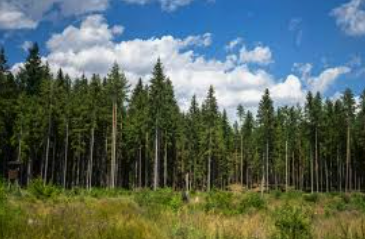

In this assignment, you’ll extend your Keras classification toolkit by training a neural network on a **balanced subset of the Forest Cover (Covertype) dataset**. We’ll begin with a simple baseline network, then study how performance changes as we vary **batch size**, **learning rate**, and apply a **cosine-decay schedule**.

For each configuration, you will consider a range of hyperparameter values, plot training/validation **loss** and **accuracy** over epochs, and determine which choice gave the best performance. 

Finally, you will consider all that you have learned and build your best model and run it on the test set. 


There are 9 graded questions, each worth 9 points, and you get 4 points for free if you complete the whole homework. 


In [2]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 22.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 42.5 MB/s eta 0:00:00:00:0100:01
   ━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  1/25 [libclang]  WARNING: The script wheel is installed in '/usr/local/python/3.12.1/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━ 11/25 [ml_dtypes]  WARNING: The script m

In [3]:
# Useful imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

random_seed = 42

tf.random.set_seed(random_seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

2025-09-15 00:09:17.982955: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-15 00:09:19.174482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-15 00:09:24.514492: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [4]:
# Utility function: Plotting Training Loss (categorical x-entropy) and Accuracy

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}')

## Load the dataset

The dataset is described in detail in the Appendix. For the purposes of this homework, we are selecting a random sample with 2747 samples in each class (to preserve balance), because the original dataset is both very large and very imbalanced, with the smallest class having 2747 samples. 

In [5]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np

# Load
X, y = fetch_covtype(return_X_y=True)   # y in {1..7}
classes, counts = np.unique(y, return_counts=True)
min_count = counts.min()                # size of rarest class (~2.7k)

# Build perfectly balanced subset (no replacement, no duplicates)
rng = np.random.default_rng(42)
idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = X[idx_bal]
y_sub = y[idx_bal] - 1                  # relabel to 0..6 for Keras
print("Subset shape:", X_sub.shape, "Class counts:", Counter(y_sub))


Subset shape: (19229, 54) Class counts: Counter({np.int32(3): 2747, np.int32(2): 2747, np.int32(6): 2747, np.int32(5): 2747, np.int32(4): 2747, np.int32(1): 2747, np.int32(0): 2747})


## Problem One: Prepare the dataset and build a baseline model

### Part A: Stratified train/test split and standardization

As in Homework 1, follow these three steps:

1. **Stratified split:**
   Use `train_test_split` with `stratify=y_sub` to preserve class proportions in both training and test sets. Be sure to set `random_state=random_seed` and `test_size=0.2`.

2. **Standardize features:**
   Scale the input features so they have mean 0 and variance 1.



In [6]:
# Your code here
# Step 1: Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_sub, y_sub,
    test_size=0.2,
    stratify=y_sub,
    random_state=random_seed
)

# Step 2: Standardize features (fit on train only, transform both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check shapes to confirm
print("X_train shape:", X_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)
print("y_train distribution:", Counter(y_train))
print("y_test distribution:", Counter(y_test))


X_train shape: (15383, 54)
X_test shape: (3846, 54)
y_train distribution: Counter({np.int32(5): 2198, np.int32(1): 2198, np.int32(0): 2198, np.int32(2): 2198, np.int32(6): 2197, np.int32(3): 2197, np.int32(4): 2197})
y_test distribution: Counter({np.int32(3): 550, np.int32(4): 550, np.int32(6): 550, np.int32(1): 549, np.int32(0): 549, np.int32(5): 549, np.int32(2): 549})


### Part B: Build, compile, train, and evaluate the network

1. **Build the model**

   * Use 2 hidden layers:  input &rarr; 64 &rarr; 32 &rarr; output.
   * Apply the `relu` activation for the hidden layers and `softmax` for the output layer.

2. **Compile the model**

    * Use the following parameters


           optimizer = Adam(learning_rate=0.0001),  
           loss = 'sparse_categorical_crossentropy',  
           metrics = ['accuracy']


4. **Train the model**

   * Run for **20 epochs**.
   * Use a `batch_size` of 32.

5. **Evaluate training**

   * Plot the training loss and accuracy curves using `plot_history`.

6. **Answer the graded questions**



2025-09-15 00:11:40.880004: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


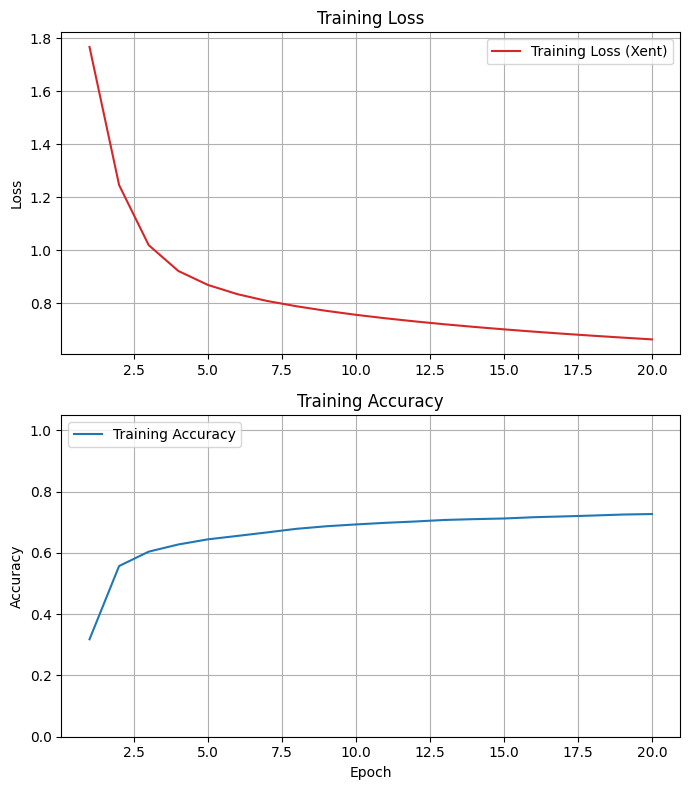

Final Training Loss:     0.6637
Final Training Accuracy: 0.7269


In [7]:
# Your code here
# Build the model
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')  # 7 classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    batch_size=32,
    epochs=20,
    verbose=0  # Set to 1 to see progress
)

# Plot training loss and accuracy
plot_history(history)

In [8]:
# Set a1a to the final training accuracy at epoch 20

a1a = history.history['accuracy'][-1]           # Replace 0.0 with your answer

In [9]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a:.4f}')  

a1a = 0.7269


## Problem Two: Batch Sizes

Next, we’ll explore how the **batch size** affects training. .

* Start with the code from Problem One.
* Run **four experiments** using a batch size of 4, 8, 16, and 128, and  displaying the results using `plot_history`.

* Answer the graded questions.

**Note:** Consider using a `for` loop!


Training with batch size = 4


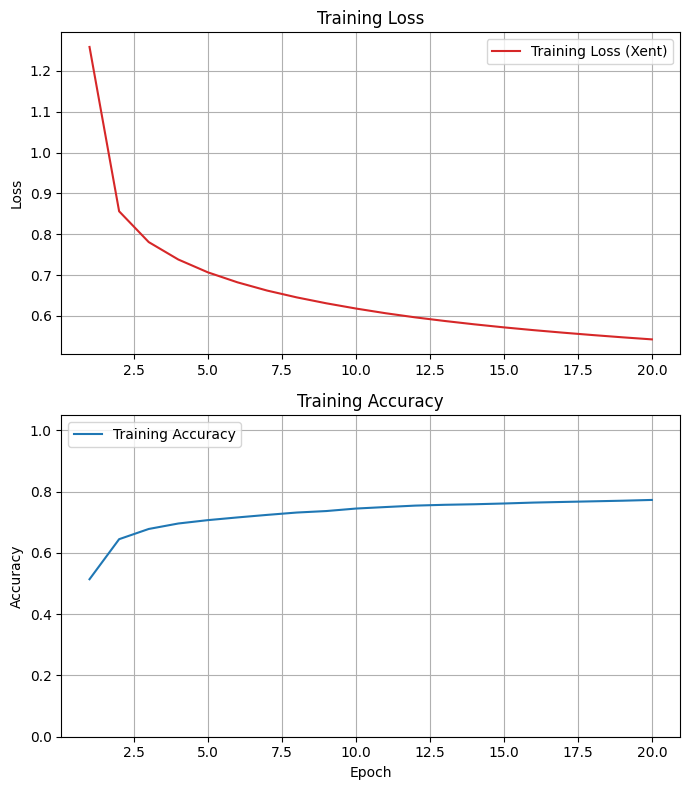

Final Training Loss:     0.5425
Final Training Accuracy: 0.7729
Final Training Accuracy for batch size 4: 0.7729

Training with batch size = 8


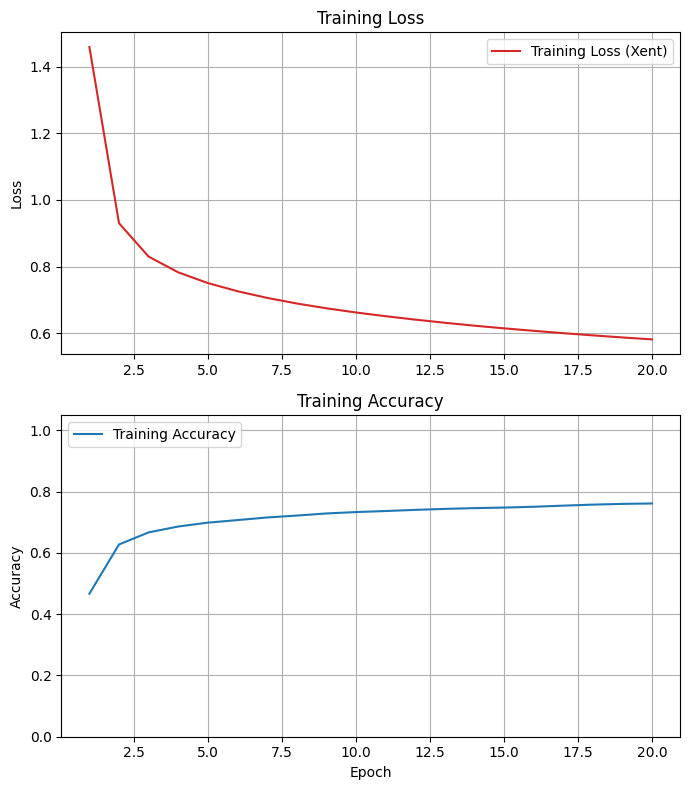

Final Training Loss:     0.5810
Final Training Accuracy: 0.7614
Final Training Accuracy for batch size 8: 0.7614

Training with batch size = 16


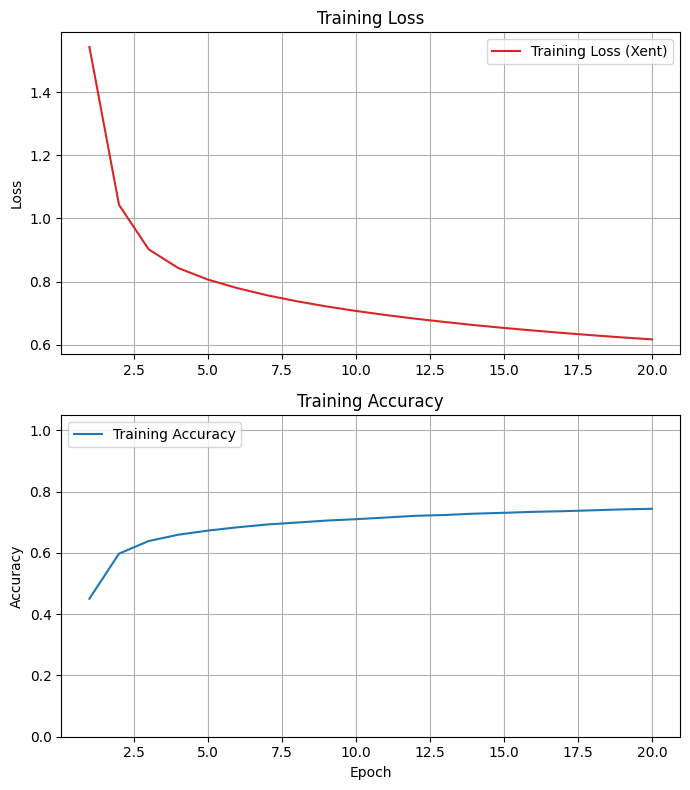

Final Training Loss:     0.6170
Final Training Accuracy: 0.7440
Final Training Accuracy for batch size 16: 0.7440

Training with batch size = 128


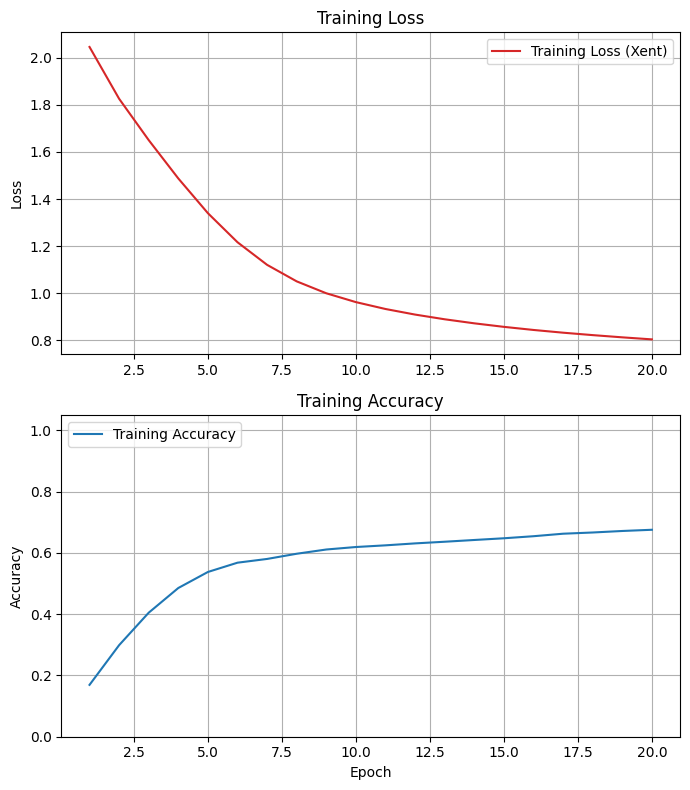

Final Training Loss:     0.8032
Final Training Accuracy: 0.6756
Final Training Accuracy for batch size 128: 0.6756


In [10]:
# Your code here
batch_sizes = [4, 8, 16, 128]
best_acc = 0.0
best_batch = 0

for bs in batch_sizes:
    print(f"\nTraining with batch size = {bs}")
    
    # Build a fresh model each time
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        X_train_scaled, y_train,
        batch_size=bs,
        epochs=20,
        verbose=0
    )

    # Plot the results
    plot_history(history)

    final_acc = history.history['accuracy'][-1]
    print(f"Final Training Accuracy for batch size {bs}: {final_acc:.4f}")

    if final_acc > best_acc:
        best_acc = final_acc
        best_batch = bs

In [11]:
# Set a2a to the batch size which produced the best accuracy score at epoch 20

a2a = best_batch            # Replace 0 with your answer

In [12]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a}') 

a2a = 4


In [13]:
# Set a2b to the best accuracy score found

a2b = best_acc             # Replace 0.0 with your answer

In [14]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7729


## Problem Three: Learning Rates

Next, we’ll explore how the **learning rate** affects training when using the Adam optimizer.

* Start with the code from **Problem One**.
* Add the `learning_rate` parameter to `Adam`.
* Run **five experiments** using the following values:

        [1e-3, 5e-4, 1e-4,5e-5, 1e-5]

* Display your results using `plot_history` and answer the graded questions.



Training with learning rate = 0.001


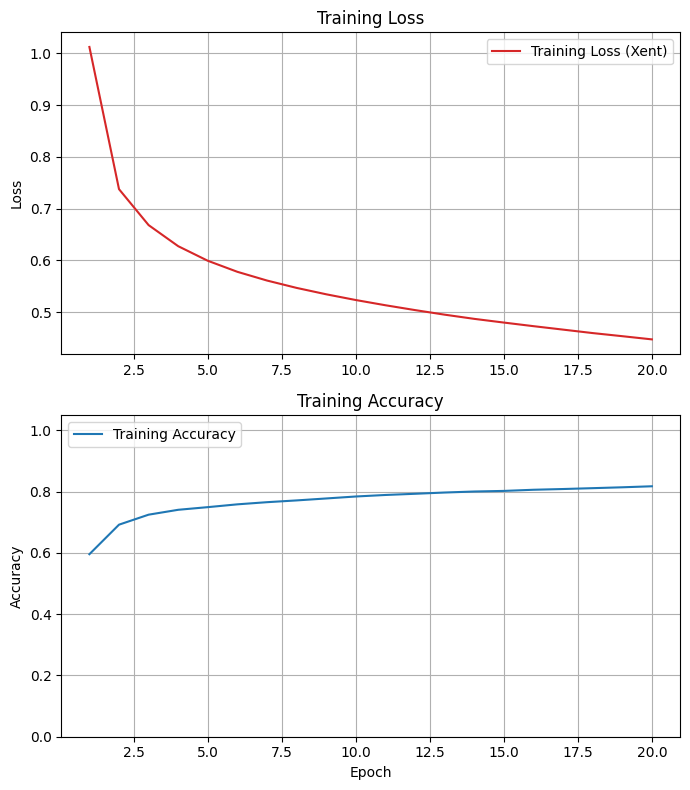

Final Training Loss:     0.4471
Final Training Accuracy: 0.8175
Final Training Accuracy with LR 0.001: 0.8175

Training with learning rate = 0.0005


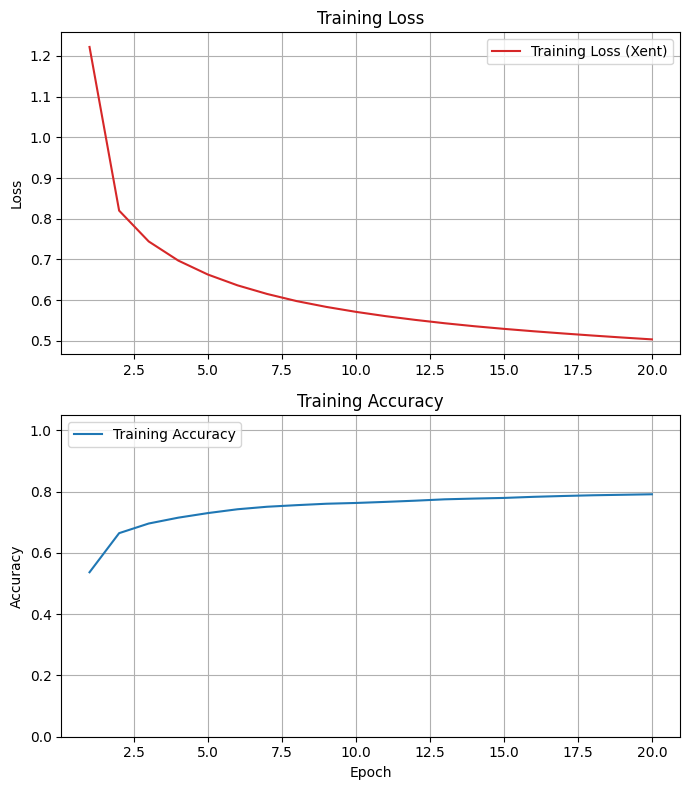

Final Training Loss:     0.5035
Final Training Accuracy: 0.7914
Final Training Accuracy with LR 0.0005: 0.7914

Training with learning rate = 0.0001


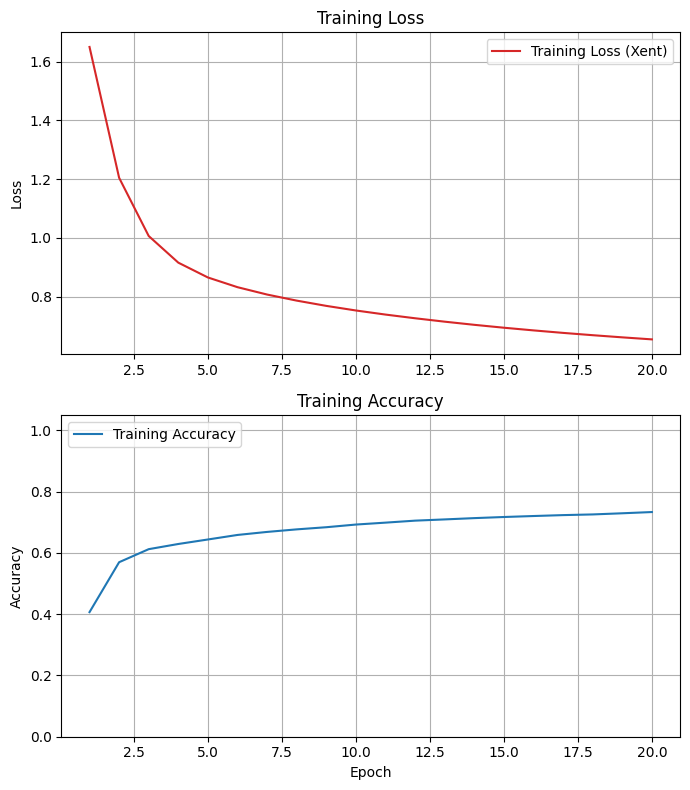

Final Training Loss:     0.6539
Final Training Accuracy: 0.7334
Final Training Accuracy with LR 0.0001: 0.7334

Training with learning rate = 5e-05


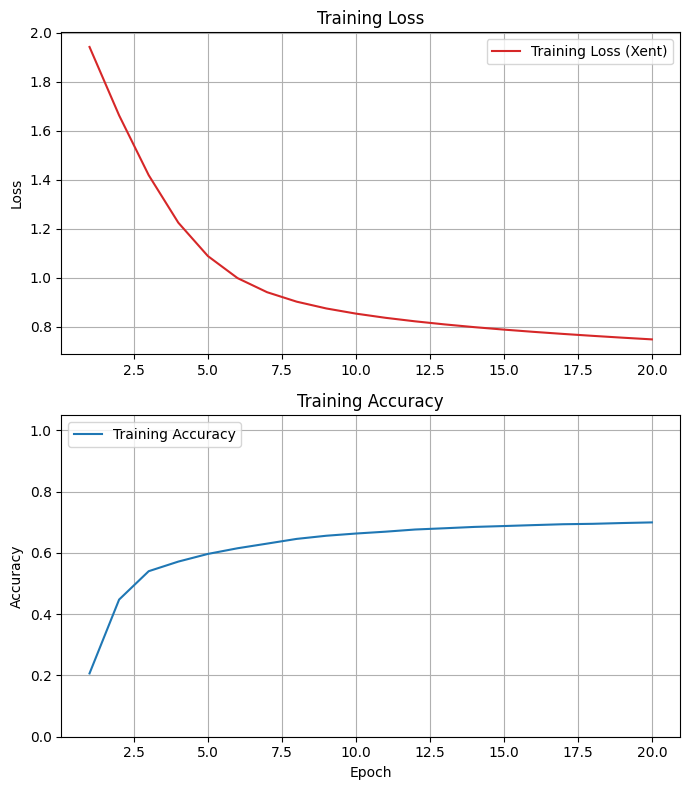

Final Training Loss:     0.7495
Final Training Accuracy: 0.6996
Final Training Accuracy with LR 5e-05: 0.6996

Training with learning rate = 1e-05


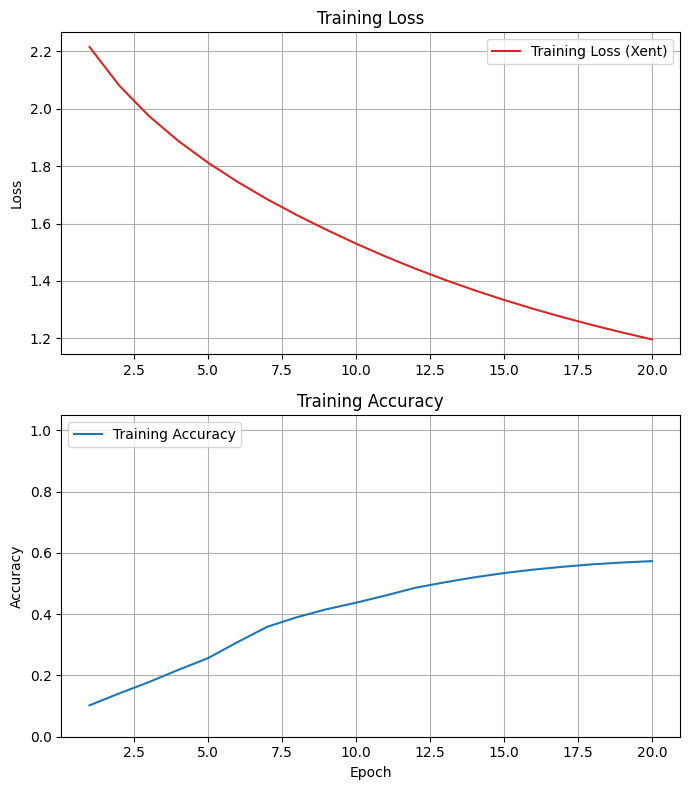

Final Training Loss:     1.1963
Final Training Accuracy: 0.5732
Final Training Accuracy with LR 1e-05: 0.5732


In [15]:
# Your code here
learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
best_acc = 0.0
best_lr = 0.0

for lr in learning_rates:
    print(f"\nTraining with learning rate = {lr}")
    
    # Build fresh model
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    # Compile with current learning rate
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train
    history = model.fit(
        X_train_scaled, y_train,
        batch_size=32,
        epochs=20,
        verbose=0
    )

    # Plot
    plot_history(history)

    # Check final training accuracy
    final_acc = history.history['accuracy'][-1]
    print(f"Final Training Accuracy with LR {lr}: {final_acc:.4f}")

    if final_acc > best_acc:
        best_acc = final_acc
        best_lr = lr


In [16]:
# Set a3a to the learning rate which produces the best (largest) accuracy at epoch 20

a3a = best_lr             # Replace 0.0 with your answer

In [17]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a:.4f}') 

a3a = 0.0010


In [18]:
# Set a3b to the accuracy found by the best learning rate

a3b = best_acc             # Replace 0.0 with your answer

In [19]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.8175


## Problem Four: Cosine Decay Learning Rate Scheduling

In this problem we'll gain some experience using the Cosine Decay learning rate scheduler with Adam. 

* Start with the code from **Problem One**.
* Define a `CosineDecay` learning rate scheduler (see `Week02_Coding.ipynb` for details)
* Use the scheduler with the Adam optimzier
* Run **five experiments** using the following values for `initial_learning_rate`:

        [1e-2, 5e-3, 1e-3,5e-4, 1e-4]

* Display your results using `plot_history` and answer the graded questions.


Training with CosineDecay, initial LR = 0.01


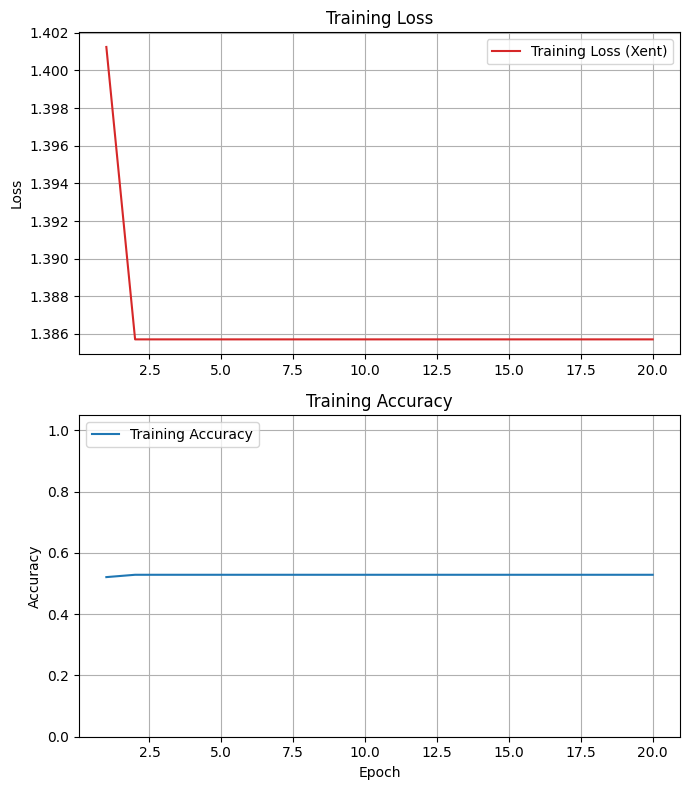

Final Training Loss:     1.3857
Final Training Accuracy: 0.5286
Final Training Accuracy with initial LR 0.01: 0.5286

Training with CosineDecay, initial LR = 0.005


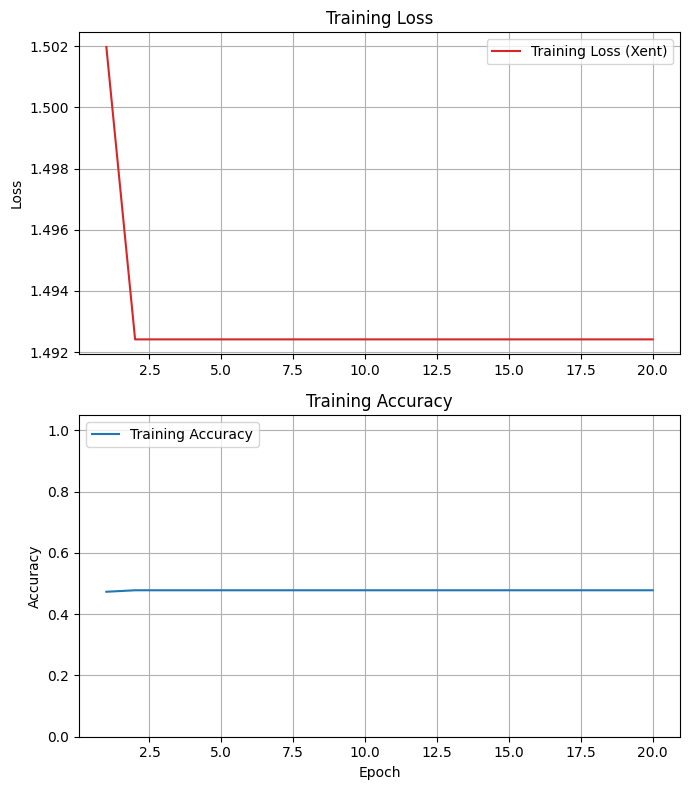

Final Training Loss:     1.4924
Final Training Accuracy: 0.4781
Final Training Accuracy with initial LR 0.005: 0.4781

Training with CosineDecay, initial LR = 0.001


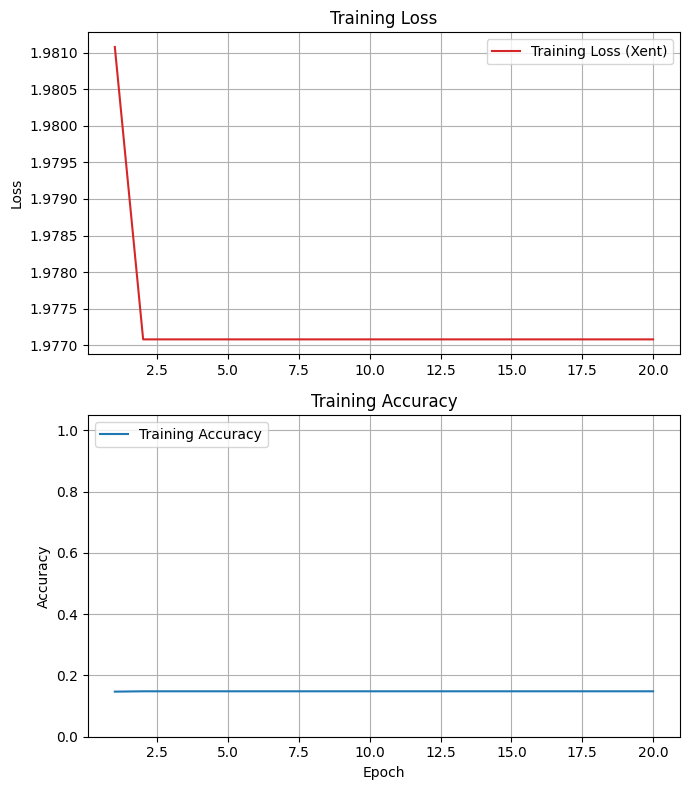

Final Training Loss:     1.9771
Final Training Accuracy: 0.1483
Final Training Accuracy with initial LR 0.001: 0.1483

Training with CosineDecay, initial LR = 0.0005


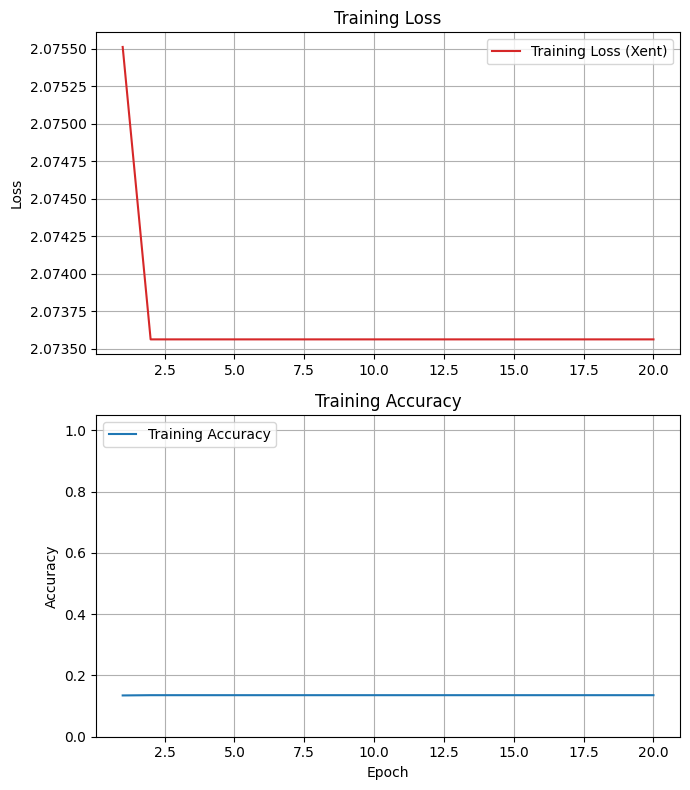

Final Training Loss:     2.0736
Final Training Accuracy: 0.1356
Final Training Accuracy with initial LR 0.0005: 0.1356

Training with CosineDecay, initial LR = 0.0001


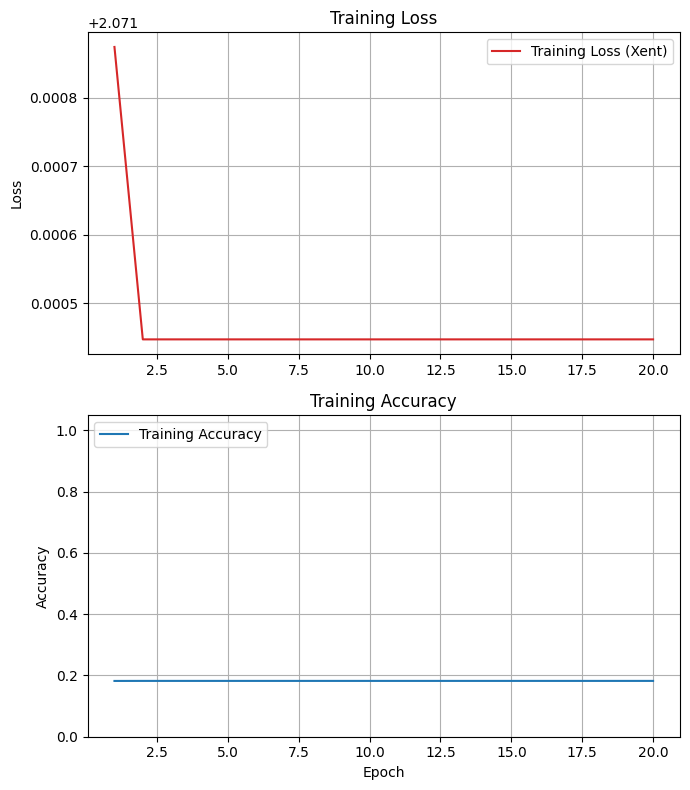

Final Training Loss:     2.0714
Final Training Accuracy: 0.1822
Final Training Accuracy with initial LR 0.0001: 0.1822


In [20]:
# Your code here

initial_lrs = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
best_acc = 0.0
best_lr = 0.0
epochs = 20

for init_lr in initial_lrs:
    print(f"\nTraining with CosineDecay, initial LR = {init_lr}")
    
    # Define cosine decay schedule
    cosine_schedule = CosineDecay(
        initial_learning_rate=init_lr,
        decay_steps=epochs,
        alpha=0.0  # Final LR will decay to 0
    )

    # Build model
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    # Compile with Adam using cosine-decay LR
    model.compile(
        optimizer=Adam(learning_rate=cosine_schedule),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train
    history = model.fit(
        X_train_scaled, y_train,
        batch_size=32,
        epochs=epochs,
        verbose=0
    )

    # Plot
    plot_history(history)

    # Track best
    final_acc = history.history['accuracy'][-1]
    print(f"Final Training Accuracy with initial LR {init_lr}: {final_acc:.4f}")

    if final_acc > best_acc:
        best_acc = final_acc
        best_lr = init_lr

In [21]:
# Set a4a to the initial learning rate which produced the best accuracy

a4a = best_lr            # Replace 0.0 with your answer

In [22]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a:.4f}') 

a4a = 0.0100


In [23]:
# Set a4b to the best accuracy found

a4b = best_acc             # Replace 0.0 with your answer

In [24]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.5286


## Problem Five: Find the best model and run on the test set

In this final problem, you must consider all the experiments you've done and pick the
set of training hyperparameters which gives you the best accuracy after 20 epochs. Do not change the model architecture. 

Your choices are:

- Which batch size?
- Cosine Decay or constant learning rate?
    - If Cosine Decay, which initial learning rate?
    - If not, which constant learning rate?

* Display your results using `plot_history`
* Run your best model on the test set
* Answer the graded questions.


**OPTIONAL: change the model architecture (but use only dense layers) and try other learning rate schedulers (exponential, step, etc.)**

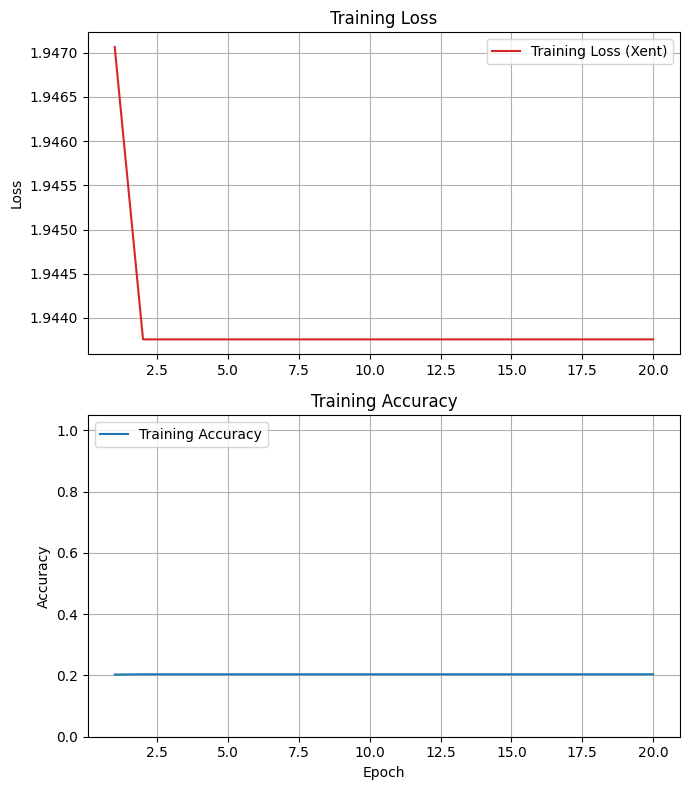

Final Training Loss:     1.9438
Final Training Accuracy: 0.2039


In [25]:
# Your code here -- add as many cells as you need

from tensorflow.keras.optimizers.schedules import CosineDecay

# Best config from previous results (update if needed)
best_batch_size = 32
use_cosine_decay = True
initial_lr = 0.001
epochs = 20

# Create learning rate scheduler if using cosine decay
if use_cosine_decay:
    lr_schedule = CosineDecay(
        initial_learning_rate=initial_lr,
        decay_steps=epochs,
        alpha=0.0
    )
else:
    lr_schedule = initial_lr

# Build model
best_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

# Compile
best_model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history = best_model.fit(
    X_train_scaled, y_train,
    batch_size=best_batch_size,
    epochs=epochs,
    verbose=0
)

# Plot training performance
plot_history(history)


In [26]:
# Set a5a to the best training accuracy found by your best model

a5a = history.history['accuracy'][-1]             # Replace 0.0 with your answer

In [27]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5a = {a5a:.4f}') 

a5a = 0.2039


In [28]:
test_loss, test_acc = best_model.evaluate(X_test_scaled, y_test, verbose=0)

In [29]:
# Set a5b to the test accuracy found by your best model

a5b = test_acc             # Replace 0.0 with your answer

In [30]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5b = {a5b:.4f}') 

a5b = 0.2064


## Reflection Questions (ungraded)

1. We trained on a perfectly balanced \~3.3% subset.
   If we *increase the subset size* (still balanced), how would you expect (a) training time, (b) the best **batch size**, and (c) the best **learning rate** to change? Why?

2. **Batch size trade-offs.**
   With epochs fixed, why do smaller batches often generalize better on tabular data than large batches? What would you change if you *must* use a large batch?

3. **More epochs, same LR.**
    If you doubled the number of epochs (no other changes), what do you think would happen to train loss/acc and test acc? 

4. **Epochs vs. LR.**
   It is natural to think that there is an inverse relationship between the number of epochs and learning rate: if you move more slowly, it will take you longer to reach your goal. Does this seem true given what we have seen in the experiments with learning rate?

# Appendix:  Forest Cover Type (Covertype) — Dataset Overview

This dataset pairs **cartographic features** of 30×30 m land plots with the **dominant tree cover type**. Your task is to predict the cover type from terrain and soil indicators—an archetypal **multi-class classification** problem on tabular data.

**At a glance**

* **Samples:** 581,012 original; we’ll use a **balanced subset** (e.g., 2747 per class) for faster, fairer training.
* **Features (54 total):**

  * **10 continuous:** elevation, aspect, slope, distances to hydrology/roads/fire points, and hillshade at 9 AM/noon/3 PM.
  * **44 binary:** **4 Wilderness\_Area** flags and **40 Soil\_Type** one-hot indicators.
* **Target (7 classes):** Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, Krummholz.

**Why it’s useful here**

* Realistic, **tabular** data with mixed feature types.
* Clear demonstration of **scaling** (continuous features) vs. **binary indicators**.
* Originally **imbalanced**, which motivates mindful evaluation (we avoid this by using a balanced subset).


Shape: (19229, 55)

Class distribution:
 Cover_Type
3    0.142857
2    0.142857
6    0.142857
5    0.142857
4    0.142857
1    0.142857
0    0.142857
Name: proportion, dtype: float64


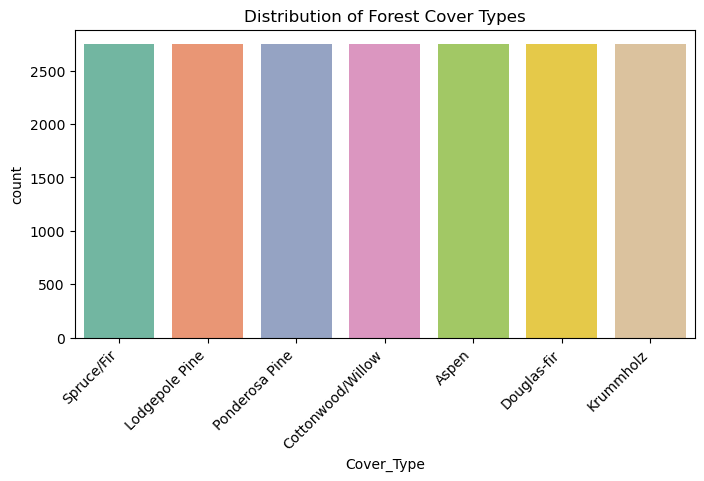

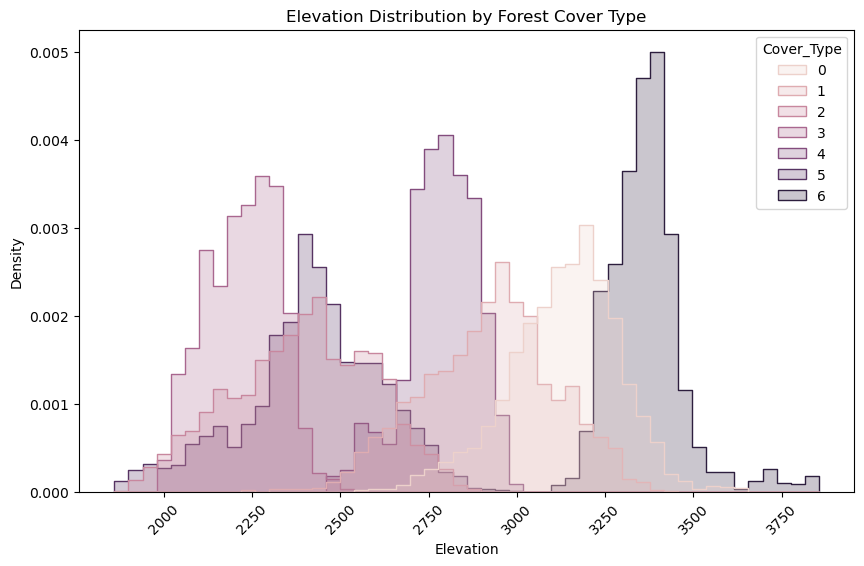

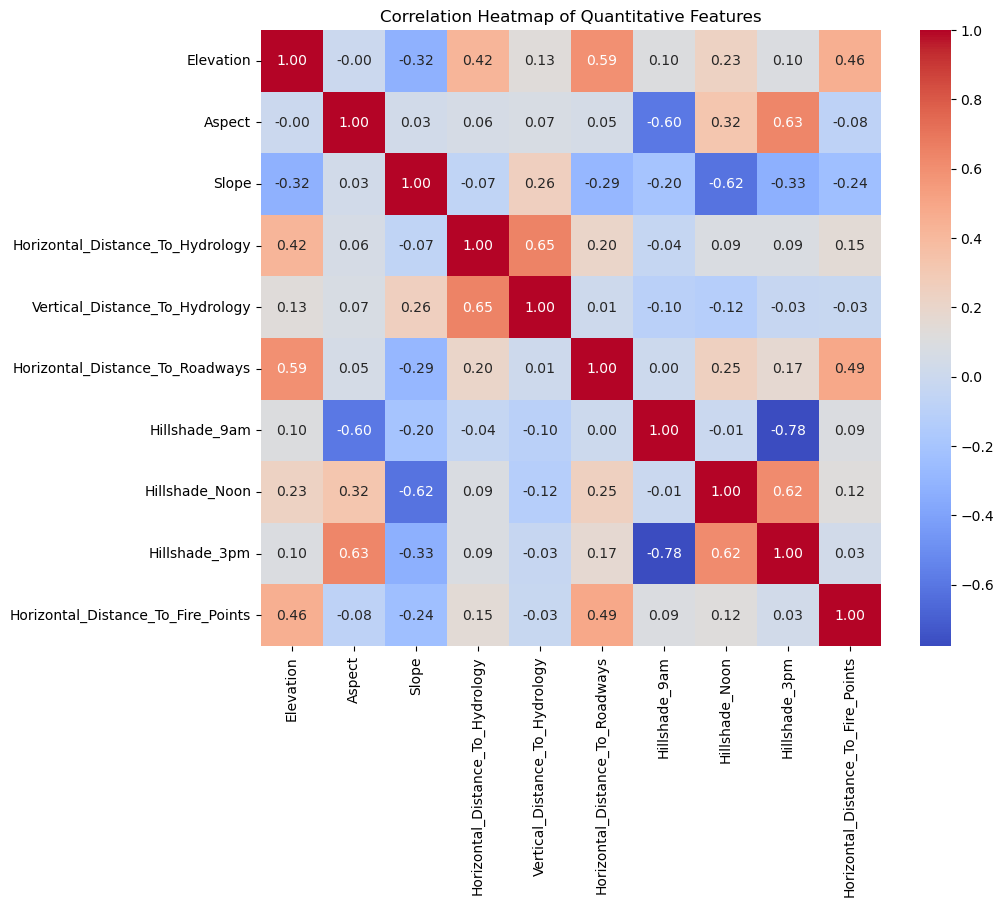

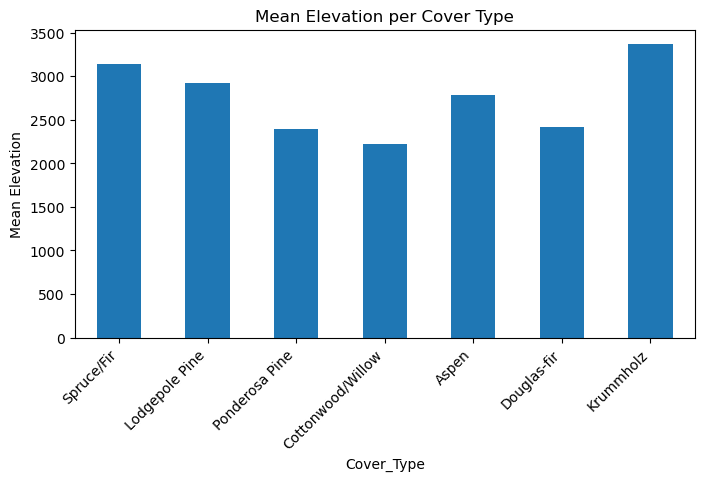

In [28]:
# Attach feature + class names
quant_features = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
wilderness_features = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_features = [f"Soil_Type{i}" for i in range(1, 41)]

feature_names = quant_features + wilderness_features + soil_features
class_names = [
    "Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine",
    "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"
]

# Create dataframe from your subset
df = pd.DataFrame(X_sub, columns=feature_names)
df["Cover_Type"] = y_sub

# 1. Basic info
print("Shape:", df.shape)
print("\nClass distribution:\n", df["Cover_Type"].value_counts(normalize=True))

# 2. Class distribution plot
plt.figure(figsize=(8,4))
sns.countplot(x="Cover_Type", hue="Cover_Type", data=df, palette="Set2", legend=False)
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.title("Distribution of Forest Cover Types")
plt.show()

# 3. Elevation distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Elevation", hue="Cover_Type",
             bins=50, element="step", stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title("Elevation Distribution by Forest Cover Type")
plt.show()

# 4. Correlation heatmap (quantitative features only)
plt.figure(figsize=(10,8))
corr = df[quant_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Quantitative Features")
plt.show()

# 5. Mean elevation per cover type
df.groupby("Cover_Type")["Elevation"].mean().plot(kind="bar", figsize=(8,4))
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.ylabel("Mean Elevation")
plt.title("Mean Elevation per Cover Type")
plt.show()
